In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import KFold
import math


**Network**

In [2]:
# CNN 3 Layers 
## Here, I exampled by first example. Only things to change for 
## second and third type image, are the size of X, L3_flat and W4

learning_rate = 0.0001

# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# input place holders
X = tf.placeholder(tf.float32, [None, 144, 144, 1]) # Input: #of datax144x144(or108x108)xdimension
Y = tf.placeholder(tf.float32, [None, 7])

# L1 ImgIn shape=(?, 144, 144, 1)_first type or (?, 108, 108, 1)_second, third type
# Weight1 (Filter 1)
W1 = tf.Variable(tf.random_normal([11, 11, 1, 32], stddev=0.01))

#    Conv     -> (?, 134, 134, 32)_first type or (?, 98, 98, 32)_second, third type
L1_conv = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='VALID')
L1_relu = tf.nn.relu(L1_conv)

#    Pool     -> (?, 67, 67, 32)_first type or (?, 49, 49, 32)_second, third type
L1_pool = tf.nn.max_pool(L1_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
L1_drop = tf.nn.dropout(L1_pool, keep_prob=keep_prob)

# L2 ImgIn shape=(?, 67, 67, 32)_first type or (?, 49, 49, 32)_second, third type
# Weight2 (Filter 2)
W2 = tf.Variable(tf.random_normal([13, 13, 32, 64], stddev=0.01))

#    Conv      -> (?, 55, 55, 64)_first type or (?, 37, 37, 64)_second, third type
L2_conv = tf.nn.conv2d(L1_drop, W2, strides=[1, 1, 1, 1], padding='VALID')
L2_relu = tf.nn.relu(L2_conv)

#    Pool      -> (?, 27, 27, 64)_first type or (?, 18, 18, 64)_second, third type
L2_pool = tf.nn.max_pool(L2_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
L2_drop = tf.nn.dropout(L2_pool, keep_prob=keep_prob)

# L3 ImgIn shape=(?, 27, 27, 64)_first type or (?, 18, 18, 64)_second, third type
# Weight3 (Filter 3)
W3 = tf.Variable(tf.random_normal([15, 15, 64, 64], stddev=0.01))

#    Conv      -> (?, 13, 13, 64)_first type or (?, 4, 4, 64)_second, third type
L3_conv = tf.nn.conv2d(L2_drop, W3, strides=[1, 1, 1, 1], padding='VALID')
L3_relu = tf.nn.relu(L3_conv)

#    Pool      -> (?, 6, 6, 64)_first type or (?, 2, 2, 64)_second, third type
L3_pool = tf.nn.max_pool(L3_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
L3_drop = tf.nn.dropout(L3_pool, keep_prob=keep_prob)

#    Reshape   ->(?, 6 * 6 * 64)_first type or (?, 2 * 2 * 64)_second, third type 
L3_flat = tf.reshape(L3_drop, [-1, 6 * 6 * 64]) # Flatten for FC

# L4 FC 6*6*64_first type (or 2*2*64_second, third type) inputs -> 7 outputs

W4 = tf.get_variable("W4", shape=[64 * 6 * 6, 7], initializer=tf.contrib.layers.xavier_initializer())

logits = tf.matmul(L3_flat, W4)

# define cost/loss & optimizer

reg_losses = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(W4) # L2 Regularization
reg_constant = 0.1  # Choose an appropriate one.

cost = tf.reduce_mean(tf.losses.softmax_cross_entropy(Y, logits)) + reg_constant * reg_losses

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # ADAM Optimizer

prediction_result = tf.argmax(logits, 1) # For prediction, choose argmax from logits

correct_prediction = tf.equal(prediction_result, tf.argmax(Y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                      
####################################################


**Read data and shuffle it**

In [3]:
Data = np.load('Cropped data/resize_cropped.npy') # First type image
#Data = np.load('Cropped data/resize_small_cropped.npy') # Second type image
#Data = np.load('Cropped data/resize_small_cropped_blur.npy') # Third type image
Label =  np.load('Cropped data/labels.npy')

# Normalizing data
for i in range(Data.shape[0]):
    mean = np.reshape(np.mean(Data[i,:,:]), [1,1])
    Data[i,:,:] = np.divide(Data[i,:,:] - mean, np.std(Data[i,:,:]))
    

In [4]:
# randomly shuffle data before training and testing
randIndx = np.arange(Data.shape[0])
np.random.seed(888) # Give random seed value
np.random.shuffle(randIndx)
# 80% of the samples are used for training. 
trainSamples=np.round(Data.shape[0]*0.8).astype(int)
# 20% of the samples are used for test
testSamples=np.round(Data.shape[0]*0.2).astype(int) 

Data_suffle = Data[randIndx,:] #Shuffle data
Label_suffle = Label[randIndx,:] #Shuffle label


In [5]:
n_features = 144 # First type image
#n_features = 108 # second, third type image

train_data, train_target = np.reshape(Data_suffle[:trainSamples,:],[trainSamples,n_features,n_features,1]), Label_suffle[:trainSamples,:]
test_data, test_target = np.reshape(Data_suffle[trainSamples:,:],[testSamples,n_features, n_features,1]), Label_suffle[trainSamples:,:]

print('Train data Configuration')
an=di=fe=ha=ne=sa=su=0
for i in range(train_target.shape[0]):
    if train_target[i,0] == 1: an+=1
    if train_target[i,1] == 1: di+=1
    if train_target[i,2] == 1: fe+=1 
    if train_target[i,3] == 1: ha+=1
    if train_target[i,4] == 1: ne+=1
    if train_target[i,5] == 1: sa+=1
    if train_target[i,6] == 1: su+=1
        
print('Angery:',an, 'Disgust:',di,'Fear:',fe,'Happy:',ha,'Netural:',ne,'Sad:',sa,'Surprise:',su) 

print('Test data Configuration')
an=di=fe=ha=ne=sa=su=0
for i in range(test_target.shape[0]):
    if test_target[i,0] == 1: an+=1
    if test_target[i,1] == 1: di+=1
    if test_target[i,2] == 1: fe+=1 
    if test_target[i,3] == 1: ha+=1
    if test_target[i,4] == 1: ne+=1
    if test_target[i,5] == 1: sa+=1
    if test_target[i,6] == 1: su+=1
        
print('Angery:',an, 'Disgust:',di,'Fear:',fe,'Happy:',ha,'Netural:',ne,'Sad:',sa,'Surprise:',su) 



Train data Configuration
Angery: 22 Disgust: 24 Fear: 28 Happy: 23 Netural: 27 Sad: 24 Surprise: 22
Test data Configuration
Angery: 8 Disgust: 5 Fear: 4 Happy: 8 Netural: 3 Sad: 7 Surprise: 8


**Main**

In [6]:
# Initialize
# Data: 213 (Total) => Train(170, 80%) / Test (43, 20%)          

# Hyper parameters
training_epochs = 60
batch_size = 51
num_cv = 10 #  153(train-fold)/17(valid-fold)
                      
valid_cost = np.zeros((training_epochs))
                      
sess = tf.Session()
sess.run(tf.global_variables_initializer())

start_time = time.time()


print('Learning started. ')

for epoch in range(training_epochs):

    total_batch = int(train_data.shape[0] / batch_size)
    cv = KFold(n_splits=num_cv, shuffle=False) # Cross validation
    for train_index, test_index in cv.split(train_data):
        cv_train_data, cv_validate_data = train_data[train_index], train_data[test_index]
        cv_train_target, cv_validate_target = train_target[train_index], train_target[test_index]    
        
        for i in range(total_batch): # SGD

            batch_xs, batch_ys = cv_train_data[batch_size*i:batch_size*(i+1),:], cv_train_target[batch_size*i:batch_size*(i+1),:]

            feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.4}

            c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)

        feed_dict = {X: cv_validate_data, Y: cv_validate_target, keep_prob: 1}
        
        valid_cost[epoch] += sess.run(cost, feed_dict=feed_dict) / num_cv


    if ((epoch+1)%5) ==0:
        print('Epoch:', '%04d' % (epoch + 1), 'Valid cost =', '{:.5f}'.format(valid_cost[epoch])) 


print('Learning Finished!')

end_time = time.time()

elapsed = end_time - start_time

print('Execution time:{:.2f} seconds'.format(elapsed))






Learning started. 
Epoch: 0005 Valid cost = 4.99401
Epoch: 0010 Valid cost = 3.05716
Epoch: 0015 Valid cost = 2.16068
Epoch: 0020 Valid cost = 1.65606
Epoch: 0025 Valid cost = 1.31398
Epoch: 0030 Valid cost = 1.08061
Epoch: 0035 Valid cost = 0.90728
Epoch: 0040 Valid cost = 0.77711
Epoch: 0045 Valid cost = 0.67846
Epoch: 0050 Valid cost = 0.59980
Epoch: 0055 Valid cost = 0.54223
Epoch: 0060 Valid cost = 0.50349
Learning Finished!
Execution time:1643.02 seconds


**Cost curve for validation set in cross validation**

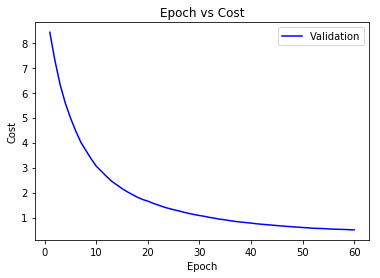

In [7]:
fig = plt.figure()
ax = plt.subplot(111)

x_axis = np.linspace(1.0, training_epochs, num=training_epochs)
ax.plot(x_axis, valid_cost,'b', label='Validation')

ax.legend()
plt.title('Epoch vs Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()



**Accuracy**

In [8]:
print('Train set Accuracy:', sess.run(accuracy, feed_dict={X: train_data, Y: train_target, keep_prob: 1}))
print('Test set Accuracy:', sess.run(accuracy, feed_dict={X: test_data, Y: test_target, keep_prob: 1}))


Train set Accuracy: 1.0
Test set Accuracy: 0.9069767


**Confusion matrix structure**



| . |    .     |   .   |    D    |   A  |   T   |    A    |  .  |          |
|:-:|:--------:|:-----:|:-------:|:----:|:-----:|:-------:|:---:|:--------:|
| . |    .     | Angry | Disgust | Fear | Happy | Neutral | Sad | Surprise |
|**P**|   Angry  |   .   |    .    |   .  |   .   |    .    |  .  |    .     |
|**R**|  Disgust |   .   |    .    |   .  |   .   |    .    |  .  |    .     |
|**E**|   Fear   |   .   |    .    |   .  |   .   |    .    |  .  |    .     |
|**D**|   Happy  |   .   |    .    |   .  |   .   |    .    |  .  |    .     |
|**I**|  Neutral |   .   |    .    |   .  |   .   |    .    |  .  |    .     |
|**C**|    Sad   |   .   |    .    |   .  |   .   |    .    |  .  |    .     |
|**T**| Surprise |   .   |    .    |   .  |   .   |    .    |  .  |    .     |


In [9]:
Train_result_mat = np.zeros((7,7)) # Confusion matrix for train set
Test_result_mat = np.zeros((7,7)) # Confusion matrix for test set

Train_prediction = sess.run(prediction_result, feed_dict={X: train_data, Y: train_target, keep_prob: 1}) # Prediction result
Test_prediction = sess.run(prediction_result, feed_dict={X: test_data, Y: test_target, keep_prob: 1}) 

for i in range(len(Train_prediction)):    
    Train_result_mat[Train_prediction[i],list(train_target[i,:]).index(1)] += 1

for i in range(len(Test_prediction)):    
    Test_result_mat[Test_prediction[i],list(test_target[i,:]).index(1)] += 1

print('Train set confusion matrix')      
print(Train_result_mat) 
print('Test set confusion matrix')      
print(Test_result_mat)  






Train set confusion matrix
[[22.  0.  0.  0.  0.  0.  0.]
 [ 0. 24.  0.  0.  0.  0.  0.]
 [ 0.  0. 28.  0.  0.  0.  0.]
 [ 0.  0.  0. 23.  0.  0.  0.]
 [ 0.  0.  0.  0. 27.  0.  0.]
 [ 0.  0.  0.  0.  0. 24.  0.]
 [ 0.  0.  0.  0.  0.  0. 22.]]
Test set confusion matrix
[[7. 0. 0. 0. 0. 0. 0.]
 [0. 5. 0. 0. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0. 0.]
 [0. 0. 0. 8. 0. 0. 1.]
 [0. 0. 0. 0. 3. 1. 1.]
 [0. 0. 0. 0. 0. 6. 0.]
 [0. 0. 0. 0. 0. 0. 6.]]


**Feature Visualization**

In [10]:
def getActivations(layer,stimuli,filter_pool,number): # Activate target feature for visualization
    units = sess.run(layer,feed_dict={X: stimuli, keep_prob:1})
    plotNNFilter(units,filter_pool,number)

In [11]:
def plotNNFilter(units,filter_pool,number):
    filters = units.shape[3]
    fig = plt.figure(figsize=(20,20))
    n_columns = 8
    n_rows = 8
    if filter_pool == 0:
        if units.shape[2] == 1:
            for i in range(filters): # First filter-level visualization
                plt.subplot(n_rows, n_columns, i+1)
                plt.title('Filter ' + str(i))
                plt.imshow(units[:,:,0,i], interpolation="nearest", cmap="gray") 
            plt.tight_layout()
        else:
            for i in range(filters): # Second and third filter-level visualization
                plt.subplot(n_rows, n_columns, i+1)
                plt.title('Filter ' + str(i))
                plt.imshow(np.mean(units[:,:,:,i], axis=2), interpolation="nearest", cmap="gray") # Take mean for converting 3D to 2D
            plt.tight_layout()
    
    if filter_pool == 1:
        for i in range(filters): # Layer-level visualization
            plt.subplot(n_rows, n_columns, i+1)
            plt.title('Layer ' + str(i))
            plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray") 
        plt.tight_layout()
    
    

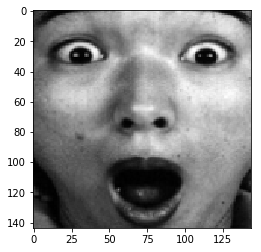

In [12]:
# Example for feature visualization
image_to_use = np.reshape(test_data[0,:,:], [1, 144, 144, 1])
plt.imshow(np.reshape(image_to_use,[144,144]), interpolation="nearest", cmap="gray")


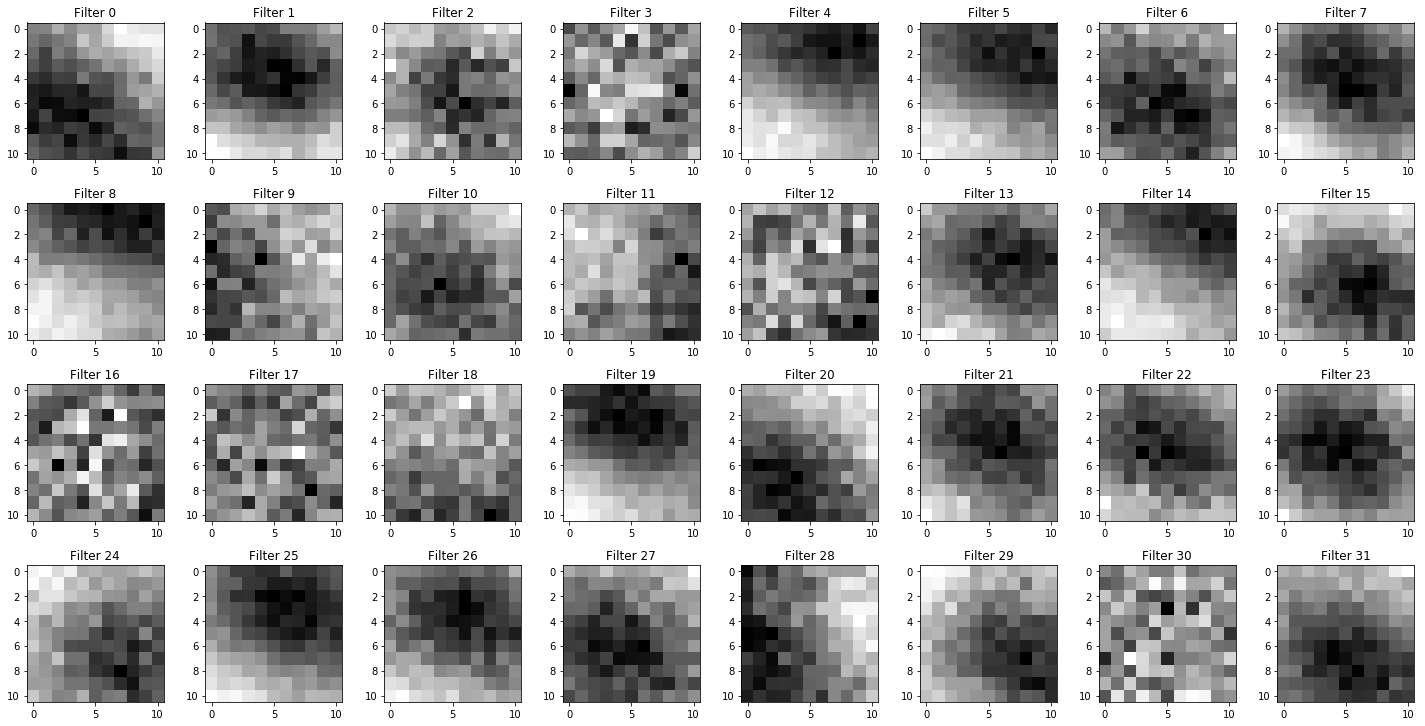

In [13]:
# First filter-level visualization
getActivations(W1, image_to_use, 0, 1)

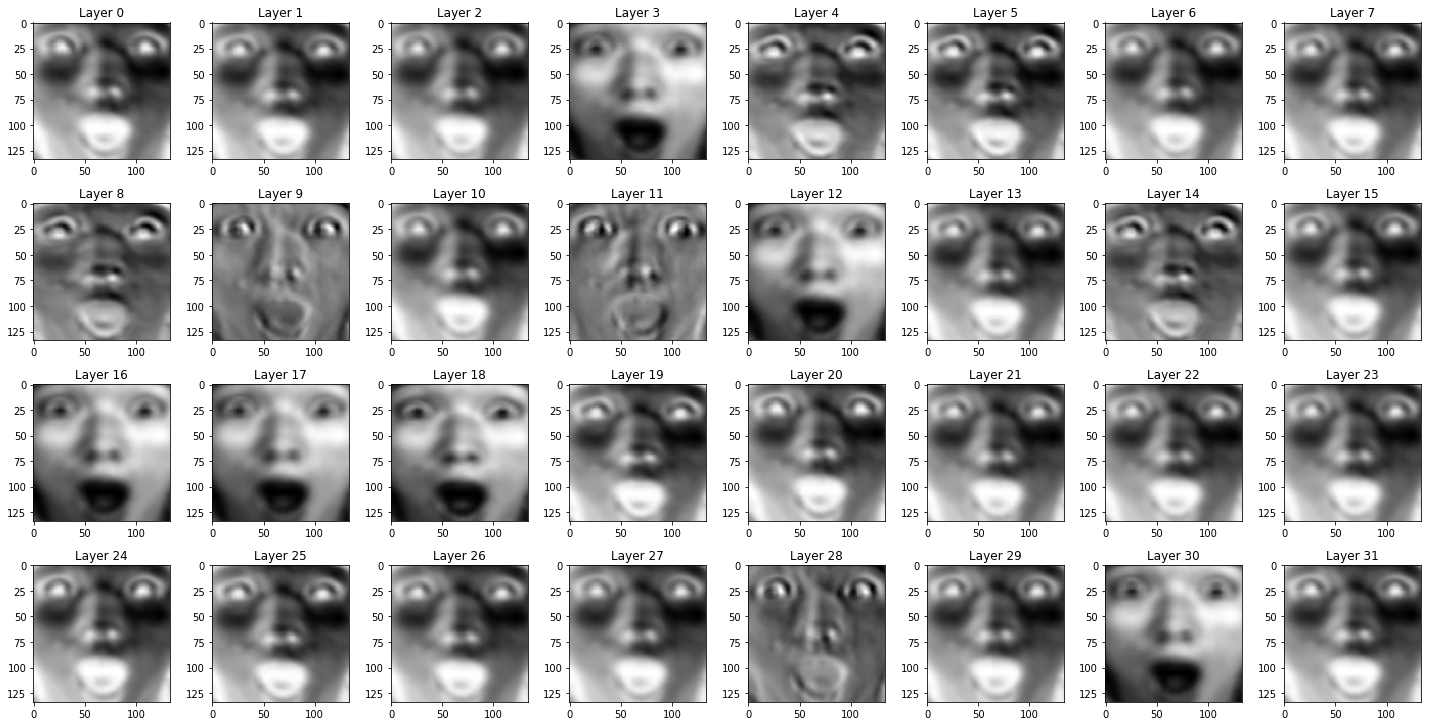

In [14]:
# First Conv layer-level visualization
getActivations(L1_conv, image_to_use, 1, 1.1)

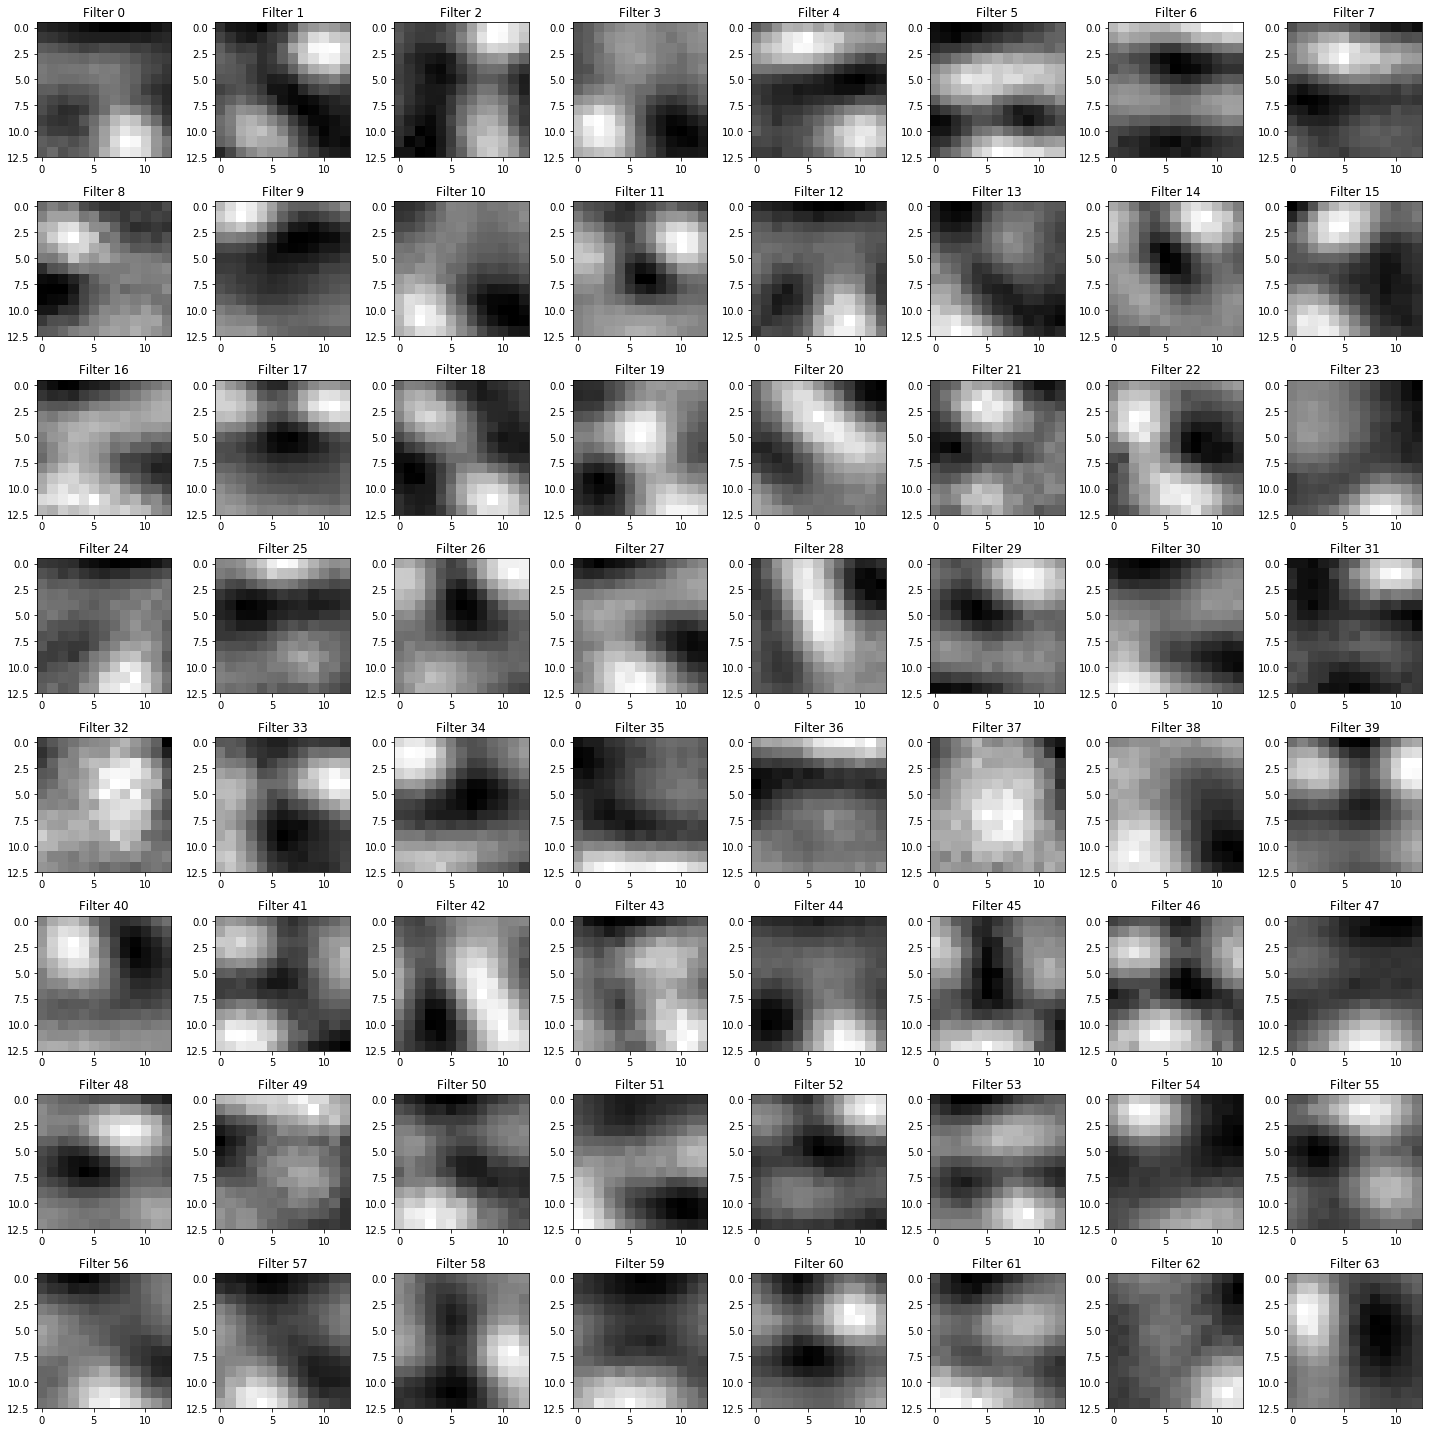

In [15]:
# Second filter-level visualization
getActivations(W2, image_to_use, 0, 2)

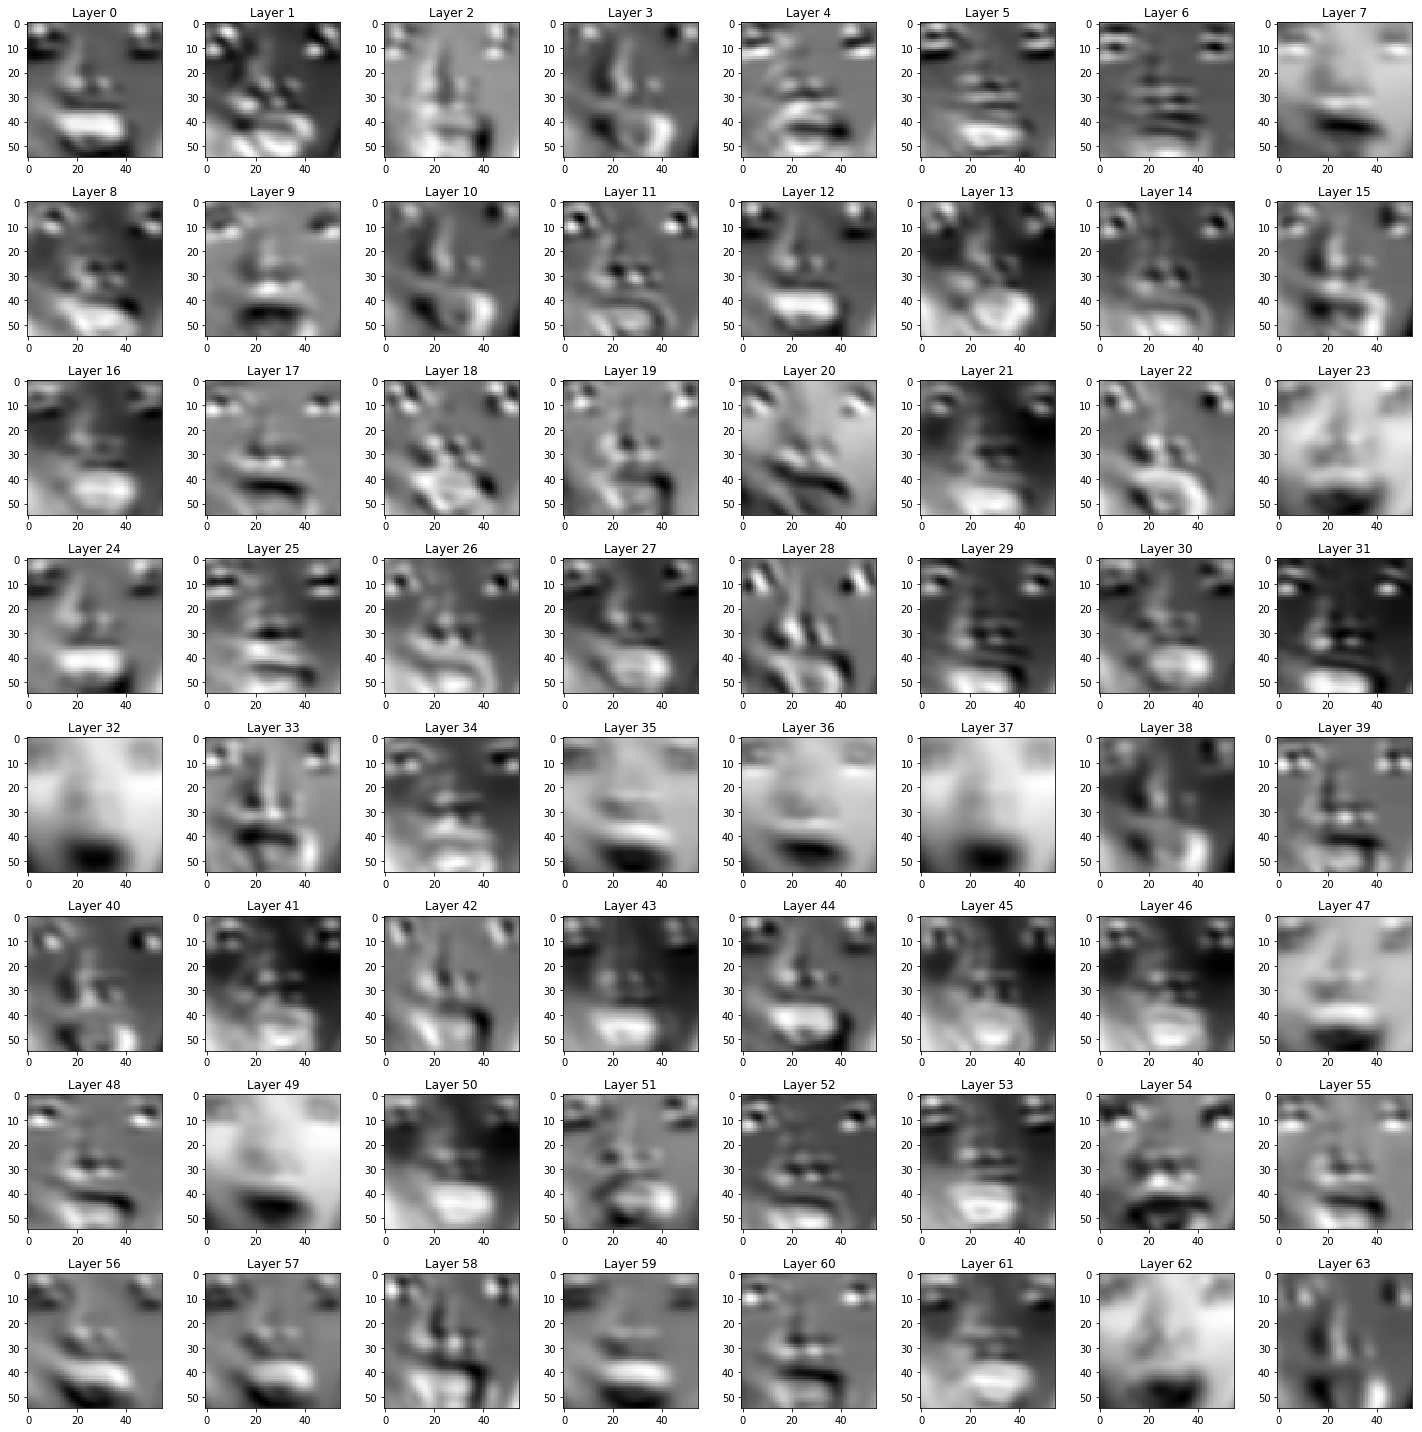

In [16]:
# Second Conv layer-level visualization
getActivations(L2_conv, image_to_use, 1, 2.1)

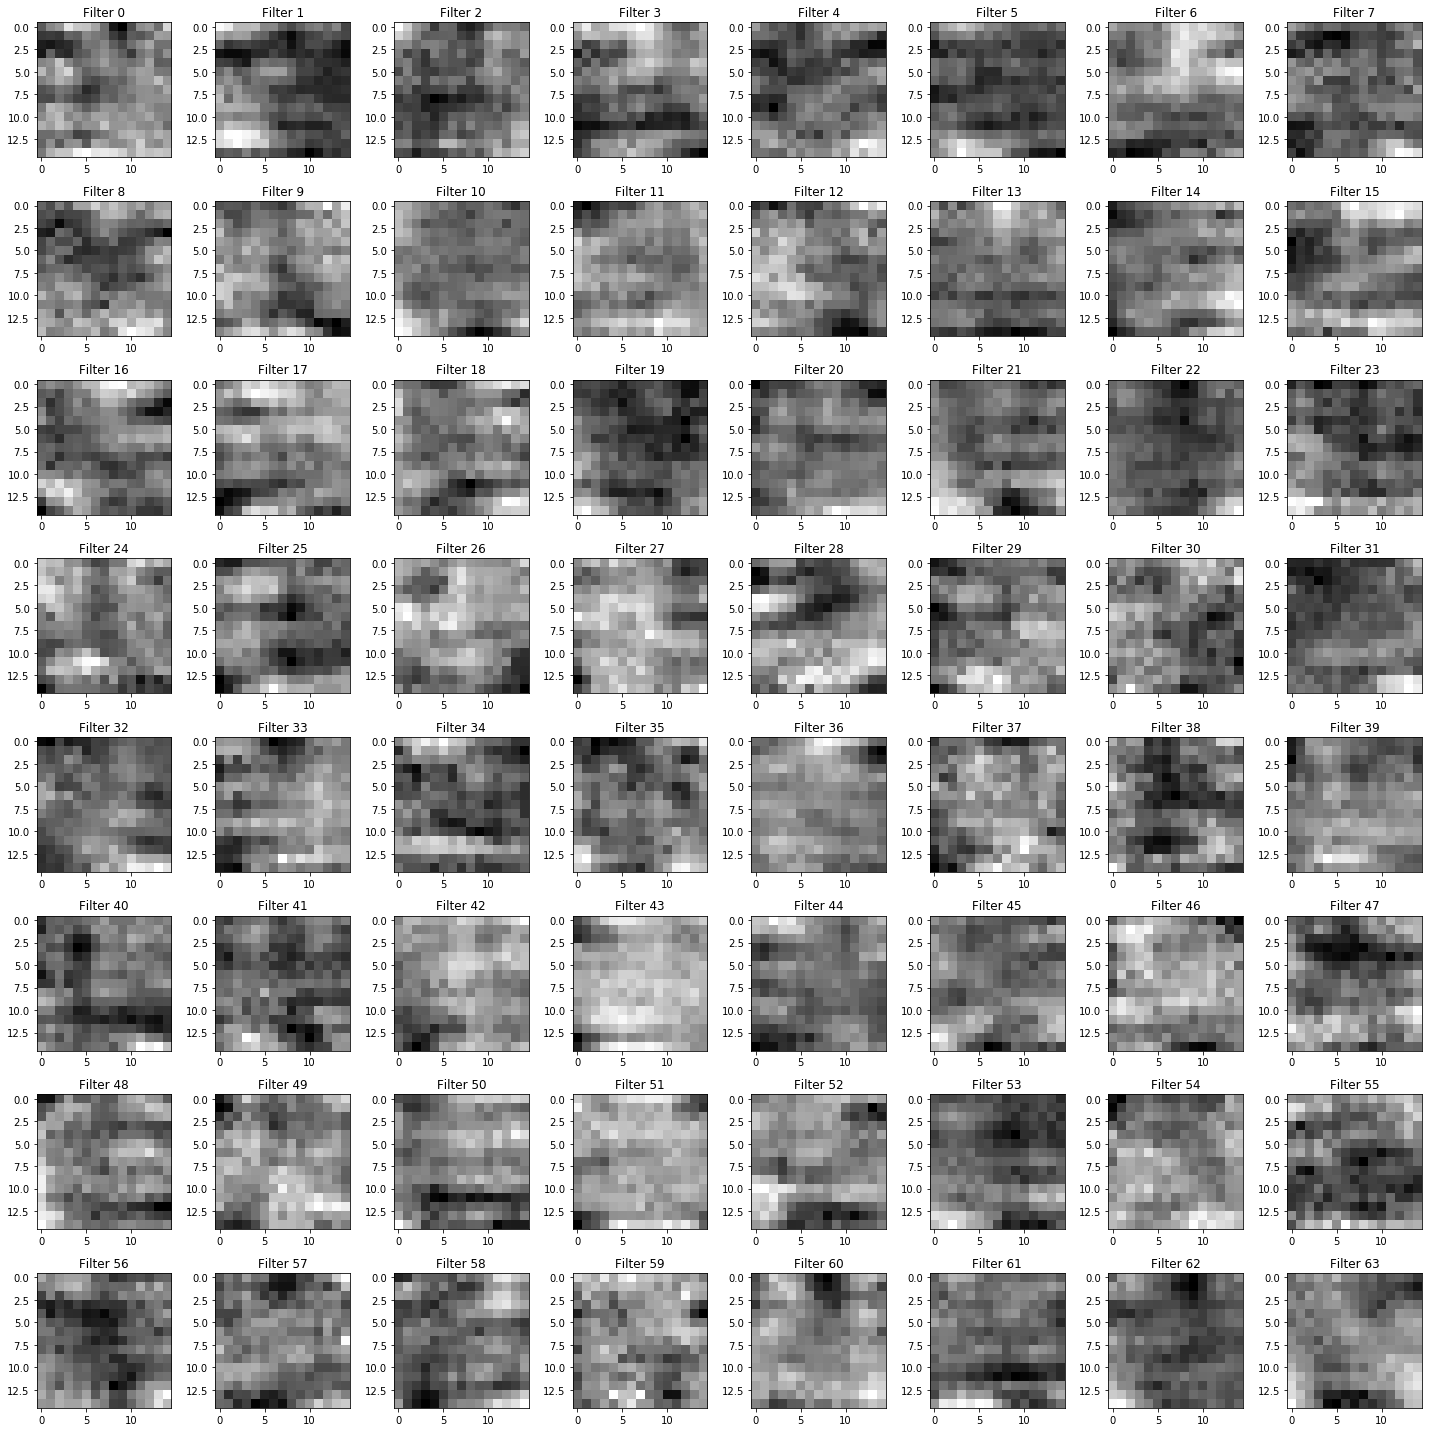

In [17]:
# Third filter-level visualization
getActivations(W3, image_to_use, 0, 3)

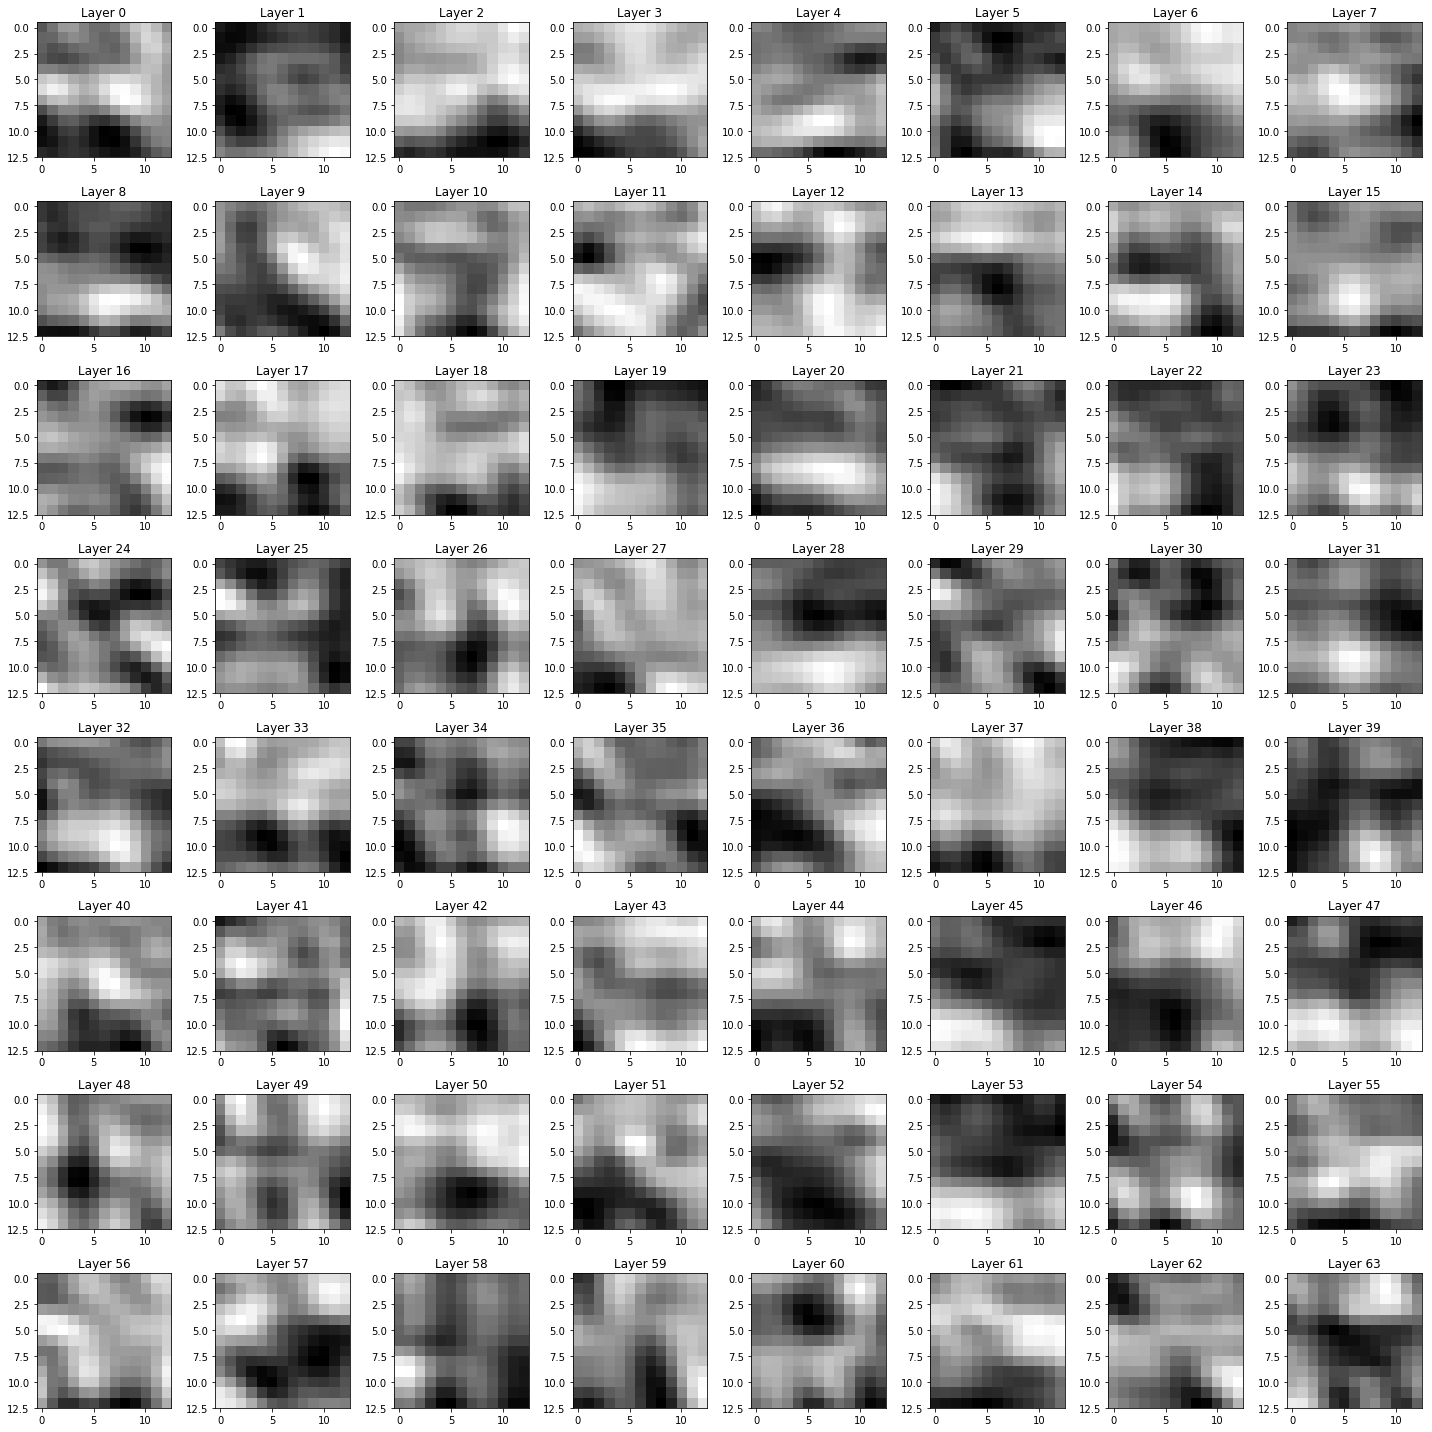

In [18]:
# Third Conv layer-level visualization
getActivations(L3_conv, image_to_use, 1, 3.1)